<a href="https://colab.research.google.com/github/PanchoMal1977/curso-github-actions/blob/main/s3_rnn_lstm_weather_prediction_daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weather Prediction using RNN and LSTM
This notebook demonstrates weather prediction for Cartagena using both RNN and LSTM models.

Basado en el Notebook de Farrukh Qureshi - Assistant Professor at Namal University Mianwali

In [1]:
!pip install tensorflow meteostat -qqq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 624.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 115.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 123.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.0 MB/s eta 0:00:00


In [2]:
# Import required libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from meteostat import Point, Daily, Hourly
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

## Data Collection
Fetch weather data for Cartagena from Meteostat

In [6]:
# Quito coordinates
latitude =-0.22985
longitude =-78.52495

# Get data from Meteostat
start = datetime(2020, 1, 3)  # 5 years ago from current date
end = datetime(2025, 8, 30)    # Current date
location = Point(latitude, longitude)
data = Daily(location, start, end)
data = data.fetch()

# Display first few rows of the data
data.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2020-01-03,15.8,11.8,21.2,<NA>,<NA>,<NA>,12.0,<NA>,1019.0,<NA>
2020-01-04,16.2,10.8,23.9,<NA>,<NA>,<NA>,12.6,<NA>,1020.4,<NA>
2020-01-05,15.6,11.5,22.2,<NA>,<NA>,<NA>,13.0,<NA>,1020.7,<NA>
2020-01-06,16.0,11.7,23.1,7.9,<NA>,<NA>,10.6,<NA>,1018.5,<NA>
2020-01-07,16.0,11.5,23.2,<NA>,<NA>,<NA>,12.3,<NA>,1017.1,<NA>


## Data Preprocessing

In [7]:
# Prepare data (we'll use temperature as our target)
df = data[['tavg']].copy()
df.ffill(inplace=True)  # Forward fill any missing values

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Create sequences for training
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# Parameters
sequence_length = 30
X, y = create_sequences(scaled_data, sequence_length)

# Split data into train and test
train_size = len(X) - 30  # Last 30 days for comparison
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input for LSTM/RNN [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Model Creation and Training

In [8]:
# Create RNN model
def create_rnn_model():
    model = Sequential([
        SimpleRNN(50, input_shape=(sequence_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Create LSTM model
def create_lstm_model():
    model = Sequential([
        LSTM(50, input_shape=(sequence_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train models
rnn_model = create_rnn_model()
lstm_model = create_lstm_model()

print("Training RNN model...")
rnn_history = rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

print("\nTraining LSTM model...")
lstm_history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Training RNN model...
Epoch 1/50


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2482
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040
Epoch 16/50
63/63 ━━━━━━━━━━━━

## Model Evaluation

In [9]:
# Make predictions
rnn_pred = rnn_model.predict(X_test)
lstm_pred = lstm_model.predict(X_test)

# Inverse transform predictions
rnn_pred = scaler.inverse_transform(rnn_pred)
lstm_pred = scaler.inverse_transform(lstm_pred)
y_test_actual = scaler.inverse_transform([y_test]).T

# Calculate error metrics
def calculate_metrics(actual, predicted):
    mse = np.mean((actual - predicted) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(actual - predicted))
    return mse, rmse, mae

rnn_metrics = calculate_metrics(y_test_actual, rnn_pred)
lstm_metrics = calculate_metrics(y_test_actual, lstm_pred)

# Print metrics
print("\nRNN Metrics:")
print(f"MSE: {rnn_metrics[0]:.2f}")
print(f"RMSE: {rnn_metrics[1]:.2f}")
print(f"MAE: {rnn_metrics[2]:.2f}")

print("\nLSTM Metrics:")
print(f"MSE: {lstm_metrics[0]:.2f}")
print(f"RMSE: {lstm_metrics[1]:.2f}")
print(f"MAE: {lstm_metrics[2]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step

RNN Metrics:
MSE: 0.92
RMSE: 0.96
MAE: 0.62

LSTM Metrics:
MSE: 0.89
RMSE: 0.94
MAE: 0.62


## Visualization

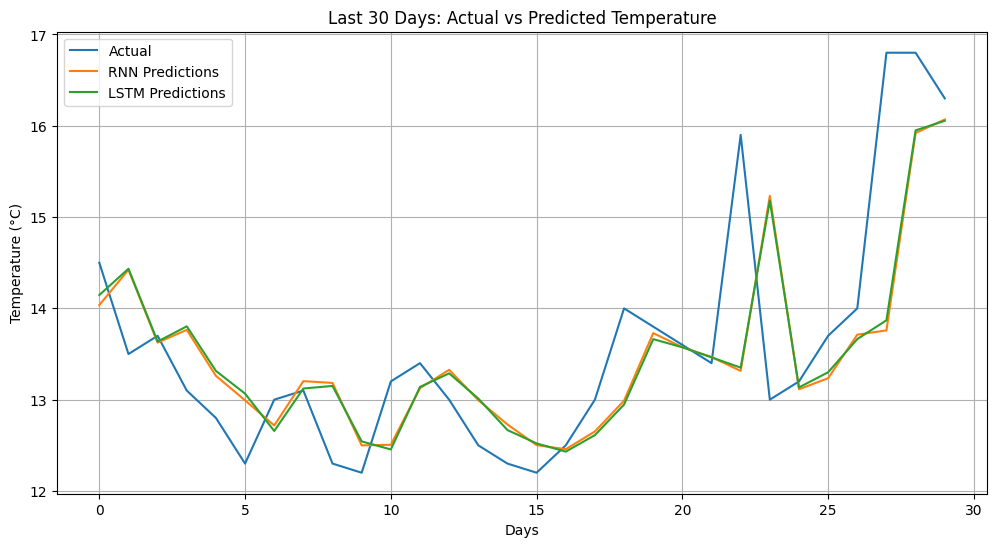

In [10]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(rnn_pred, label='RNN Predictions')
plt.plot(lstm_pred, label='LSTM Predictions')
plt.title('Last 30 Days: Actual vs Predicted Temperature')
plt.xlabel('Days')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

## Future Predictions

In [11]:
# Predict next 5 days
last_sequence = scaled_data[-sequence_length:]
last_sequence = last_sequence.reshape(1, sequence_length, 1)

future_rnn = []
future_lstm = []

for _ in range(5):
    # RNN prediction
    rnn_next = rnn_model.predict(last_sequence)
    future_rnn.append(rnn_next[0, 0])

    # LSTM prediction
    lstm_next = lstm_model.predict(last_sequence)
    future_lstm.append(lstm_next[0, 0])

    # Update sequence
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[0, -1, 0] = lstm_next[0, 0]

# Convert predictions to temperature values
future_rnn = scaler.inverse_transform(np.array(future_rnn).reshape(-1, 1))
future_lstm = scaler.inverse_transform(np.array(future_lstm).reshape(-1, 1))

print("\nNext 5 days temperature predictions:")
for i in range(5):
    print(f"Day {i+1}:")
    print(f"RNN: {future_rnn[i][0]:.2f}°C")
    print(f"LSTM: {future_lstm[i][0]:.2f}°C")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Next 5 days temperature predictions:
Day 1:
RNN: 15.75°C
LSTM: 15.75°C
Day 2:
RNN: 15.27°C
LSTM: 15.44°C
Day 3:
RNN: 15.13°C
LSTM: 15.27°C
Day 4:
RNN: 15.01°C
LSTM: 15.17°C
Day 5:
RNN: 15.12°C
LSTM: 15.10°C
